### Load data

In [1]:
import os
import multiprocessing.dummy as mp

In [2]:
kalimat_base = "data/KalimatCorpus-2.0"
expected_dirs = os.listdir(kalimat_base)

In [3]:
def check_kalimat_structure_os():
    missing = [d for d in expected_dirs if not os.path.isdir(os.path.join(kalimat_base, d))]
    
    if missing:
        print(f"❌ Missing folders: {missing}")
    else:
        count = 0
        for d in expected_dirs:
            folder_path = os.path.join(kalimat_base, d)
            count += len([f for f in os.listdir(folder_path)])
        print(f"✅ Kalimat Corpus is ready with {count} .txt files")

check_kalimat_structure_os()

✅ Kalimat Corpus is ready with 18256 .txt files


In [4]:
def load_kalimat_articles(category):
    category_path = os.path.join(kalimat_base, category)
    if not os.path.isdir(category_path):
        print(f"❌ Category '{category}' does not exist in the Kalimat Corpus.")
        return []

    articles = []
    for filename in os.listdir(category_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                words = [line.strip() for line in f if line.strip()]
                text = " ".join(words)
                articles.append({
                    "category": category,
                    "filename": filename,
                    "text": text,
                    "word_count": len(words)
                })

    print(f"✅ Loaded {len(articles)} articles from category '{category}'")
    return articles

In [5]:
def load_all_articles_parallel():
    with mp.Pool(processes=min(len(expected_dirs), int(os.cpu_count() / 2))) as pool:
        results = pool.map(load_kalimat_articles, expected_dirs)
    
    dataset = [article for category_articles in results for article in category_articles]
    return dataset

In [6]:
if __name__ == "__main__": # To solve the multiprocessing issue on Windows
    dataset = load_all_articles_parallel()
    print(f"✅ Dataset loaded with {len(dataset)} articles.")

✅ Loaded 1689 articles from category 'articlesInternational'
✅ Loaded 2495 articles from category 'articlesCulture'
✅ Loaded 3265 articles from category 'articlesEconomy'
✅ Loaded 3237 articles from category 'articlesLocal'
✅ Loaded 3475 articles from category 'articlesReligion'
✅ Loaded 4095 articles from category 'articlesSports'
✅ Dataset loaded with 18256 articles.


### Preprocessing

In [20]:
import pandas as pd
df = pd.DataFrame(dataset)
df.head()

,category,filename,text,word_count
0,articlesCulture,culturecapr1.txt,كتب سالم الرحبي : تنطلق اليوم الدورة البرامجية...,2732
1,articlesCulture,culturecapr1005.txt,كتب - فيصل العلوي : شاركت السلطنة صباح امس دول...,835
2,articlesCulture,culturecapr1006.txt,اربعة عروض على مسرح الشباب وعرض في الرستاق ثم ...,691
3,articlesCulture,culturecapr1007.txt,حاوره خالد عبداللطيف : حين يناقش الموضوع الثقا...,1972
4,articlesCulture,culturecapr1008.txt,افتتح صباح أمس بقاعة الموسيقي في جامعة السلطان...,329


In [8]:
import string
import nltk
from nltk.corpus import stopwords
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report
import numpy as np 


In [9]:
nltk.download('stopwords')
nltk.download('punkt')

arabic_stopwords = set(stopwords.words('arabic'))
len(arabic_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sauda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sauda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


701

In [10]:
def preprocess_text(text):
    text = re.sub(r'\p{P}+|\$', '', text)  # remove all punctuation (English + Arabic)
    text = re.sub(r'[0-9٠-٩]', '', text)  # remove Arabic and English digits
    text = re.sub(r'[a-zA-Z]', '', text)  # remove English letters
    text = re.sub(r'[\u064B-\u0652]', '', text)  # remove Arabic diacritics
    text = re.sub(r'\s+', ' ', text).strip()  # clean extra spaces

    tokens = text.split()
    tokens = [word for word in tokens if word not in arabic_stopwords]

    return ' '.join(tokens)

preprocess_text("!مرحباً... هذا نَصٌّ تَجْرِيبِيٌ يحتوي على 123 أرقام ٤٥٦، علامات ترقيم @#$%، كلمات إنجليزية like This.")

'مرحبا نص تجريبي يحتوي أرقام علامات ترقيم كلمات إنجليزية'

In [ ]:
df['processed_text'] = df['text'].apply(preprocess_text) # apply the function to each row

### Visualization

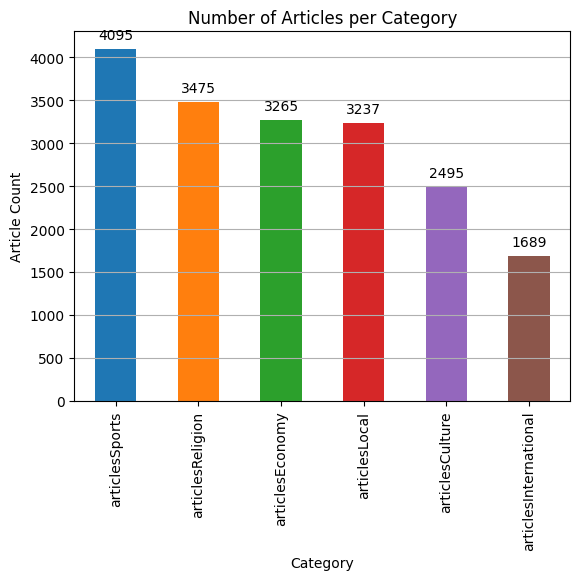

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

counts = df['category'].value_counts()
colors = plt.cm.tab10(range(len(counts)))

ax = counts.plot(kind="bar", color=colors, title="Number of Articles per Category")
plt.xlabel("Category")
plt.ylabel("Article Count")
plt.grid(axis='y')

# Add counts above each bar
for i, count in enumerate(counts):
    ax.annotate(str(count), xy=(i, count), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.show()

In [ ]:
df = df.drop_duplicates(subset=['processed_text']) # drop duplicates based on the original text

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

In [ ]:

X = tfidf_matrix
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=260, random_state=42, n_jobs=-1)


rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {np.mean(cv_scores):.4f}')

print("\n Model Evaluation")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=sorted(y.unique()))
print(class_report)


before we put our preporcess in the class we got 
Accuracy: 0.9167579408543264

Classification Report:
                       precision    recall  f1-score   support

      articlesCulture       0.91      0.83      0.87       499
      articlesEconomy       0.90      0.84      0.87       653
articlesInternational       0.90      0.91      0.91       338
        articlesLocal       0.81      0.88      0.84       648
     articlesReligion       0.97      1.00      0.99       695
       articlesSports       0.98      0.99      0.99       819

             accuracy                           0.92      3652
            macro avg       0.91      0.91      0.91      3652
         weighted avg       0.92      0.92      0.92      3652
